In [1]:
import json

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

In [2]:
def data_load():
    
    files = {
        'df_4': 'Indoor_sensor_provider_4.csv',
        'df_1': 'Indoor_sensor_provider_1.csv',
        'df_2': 'Indoor_sensor_provider_2.csv',
        'df_3': 'Indoor_sensor_provider_3.csv',
        'df_5': 'Indoor_sensor_provider_5.csv',
        'df_6': 'Indoor_sensor_provider_6.csv',
        'df_ref': 'Indoor_referent_device.csv'
    }

    dfs = {name: pd.read_csv(f'./data/data/{path}', index_col=0) for name, path in files.items()}
    
    timestamp_map = {
    'df_4': 'timestamp', 'df_1': 'timestamp', 'df_2': 'Timestamp',
    'df_3': 'Timestamp', 'df_5': 'Timestamp', 'df_ref': 'timestamp'
    }

    for key in dfs:
        if key == 'df_ref': 
            dfs[key].set_index('Timestamp', inplace=True)
            dfs[key].index = pd.to_datetime(dfs[key].index)
        else:
            dfs[key].index = pd.to_datetime(dfs[key].index)
    
    return dfs

In [3]:
dfs = data_load()

In [4]:
names = {
    'df_4':'PRVD4',
    'df_1':'PRVD1',
    'df_2':'PRVD2',
    'df_3':'PRVD3',
    'df_5':'PRVD5',
    'df_6':'PRVD6',
    'df_ref':'Indoor reference device',
}

# Experiments 

In [5]:
with open('./data/experiments.json', 'r') as f:
    experiments_data = json.load(f)

## Select an experiment

In [6]:
print(list(experiments_data['experiments'].keys()))

['Door opened to the Garden', 'Door opened to the Hallway', 'Doors opened to the Garden and the Hallway', 'Exercise Rowing with closed door to the Garden', 'Exercise Rowing with opened door to the Garden', 'Human Presence', 'Diffuser with Water inside', 'Diffuser with Oil inside', 'Car working in Garden, distance 3 m', 'Car working in Garden, distance 5 m', 'Gas Burner working with closed door', 'Gas Burner working with opened door', 'Candle with closed door', 'Scented Candle', 'Candle with opened door', 'Vacuum Cleaning with windows closed', 'Odor from Neighbors', 'Heater', 'Aquarium Pump', 'Tar (Neighbor Burning)', 'Central Heating', 'VOC Tubes - Car', 'VOC Tubes - Diffuser (Oil)', 'VOC Tubes - Gas Burner', 'VOC Tubes - Candle', 'Diffuser with Oil repeated', 'Boiling Water (Gas) with doors closed']


In [13]:
selected_experiment = 'Human Presence'

In [14]:
experiments_data['experiments'][selected_experiment]

[{'start': '2024-10-19 12:02', 'end': '2024-10-19 12:53'},
 {'start': '2024-10-19 13:34', 'end': '2024-10-19 14:08'}]

# Show experiments


In [15]:
def crop_time(df, experiment_start, experiment_end, buffer=20):
    
    start_time = pd.Timestamp(experiment_start)
    end_time = pd.Timestamp(experiment_end)

    start_with_buffer = start_time - pd.Timedelta(minutes=buffer)
    end_with_buffer = end_time + pd.Timedelta(minutes=buffer)

    return df[(df.index >= start_with_buffer) & (df.index <= end_with_buffer)]

In [16]:
co2_columns = {
    'df_4': 'CO2 (ppm)_sensor_1',
    'df_1': 'CO2[ppm]',
    'df_2': 'CO2 (ppm)',
    'df_3': 'CO2 (ppm)',
    'df_5': 'CO2 (ppm)_sensor_1',
    'df_6': 'CO2 (ppm)_sensor_10',
    'df_ref': 'CO2 [ppm]'
    }

pm10_columns = {'df_4': 'PM10 (µg/m3)_sensor_1',
 'df_1': 'PM10[ugm3]',
 'df_2': 'PM 10 (µg/m3)',
 'df_3': 'PM 10 (µg/m3)',
 'df_5': 'PM10 (ppb)_sensor_1',
 'df_6': 'PM10 (µg/m3)_sensor_10',
 'df_ref': 'PM10 [µg/m³]'}

In [17]:
def plot_comparison_chart(dfs, columns_dict, names_dict, start_time, end_time, 
                        param_name='CO2', param_unit='ppm', param_symbol=None, 
                        ref_col_name='CO2 [ppm]'):
    
    sns.set_style("whitegrid")
    sns.set_palette("husl", 8)
    
    if param_symbol:
        title_param = f"{param_name}$_{{{param_symbol}}}$"
    else:
        title_param = param_name
    
    colors = sns.color_palette("husl", len(columns_dict))
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

    for i, (name, col) in enumerate(columns_dict.items()):
        if name != 'df_ref':  
            line_style = '--' if i % 2 == 0 else ':'  
            sns.lineplot(ax=axes[0], 
                        data=dfs[name][col], 
                        label=names_dict[name], 
                        linewidth=2, 
                        color=colors[i], 
                        linestyle=line_style)
    
    axes[0].set_title(f'{title_param} Concentration - Low-Cost Sensors', 
                    fontsize=30, fontweight='bold')
    axes[0].set_ylabel(f'{title_param} ({param_unit})', fontsize=25, fontweight='bold')
    axes[0].legend(fontsize=25, loc='best', frameon=False)

    sns.lineplot(ax=axes[1], 
                data=dfs['df_ref'][ref_col_name], 
                label='Reference Device', 
                linewidth=3, 
                color='black')
    
    axes[1].set_title(f'{title_param} Concentration - Reference Device', 
                    fontsize=30, fontweight='bold')
    axes[1].set_xlabel('Time', fontsize=25, fontweight='bold')
    axes[1].set_ylabel(f'{title_param} ({param_unit})', fontsize=25, fontweight='bold')
    axes[1].legend(fontsize=20, loc='best', frameon=False)
    
    for ax in axes:
        ax.axvspan(dfs['df_ref'].index[0], start_time, 
                color='lightblue', alpha=0.2, label='Before Start')
        ax.axvspan(start_time, end_time, 
                color='lightgreen', alpha=0.25, label='During Event')
        ax.axvspan(end_time, dfs['df_ref'].index[-1], 
                color='lightcoral', alpha=0.2, label='After Event')

        xticks = dfs['df_ref'].index[::5]
        ax.set_xticks(xticks)
    
        ax.tick_params(axis='x', rotation=45, labelsize=20, width=1.5)
        ax.tick_params(axis='y', labelsize=20, width=1.5)
        ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.5)

    axes[0].legend(fontsize=20, loc='best')
    axes[1].legend(fontsize=20, loc='best')
    
    plt.tight_layout()
    
    return fig, axes

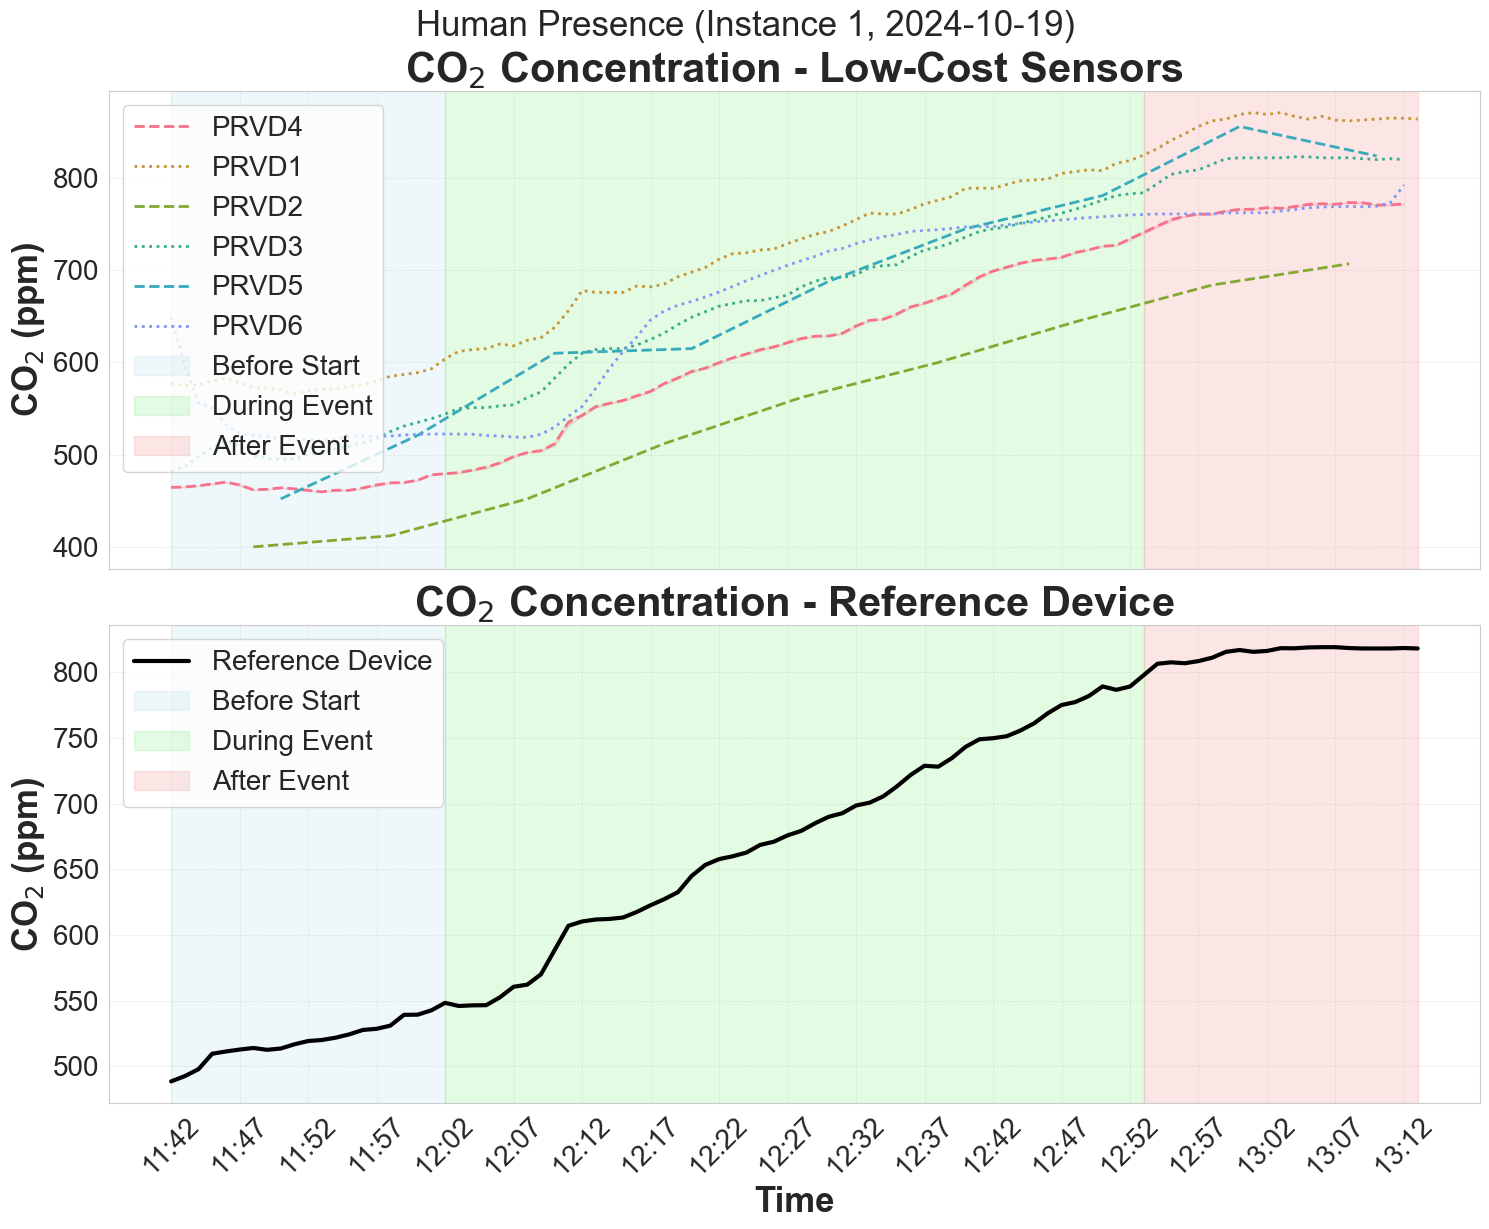

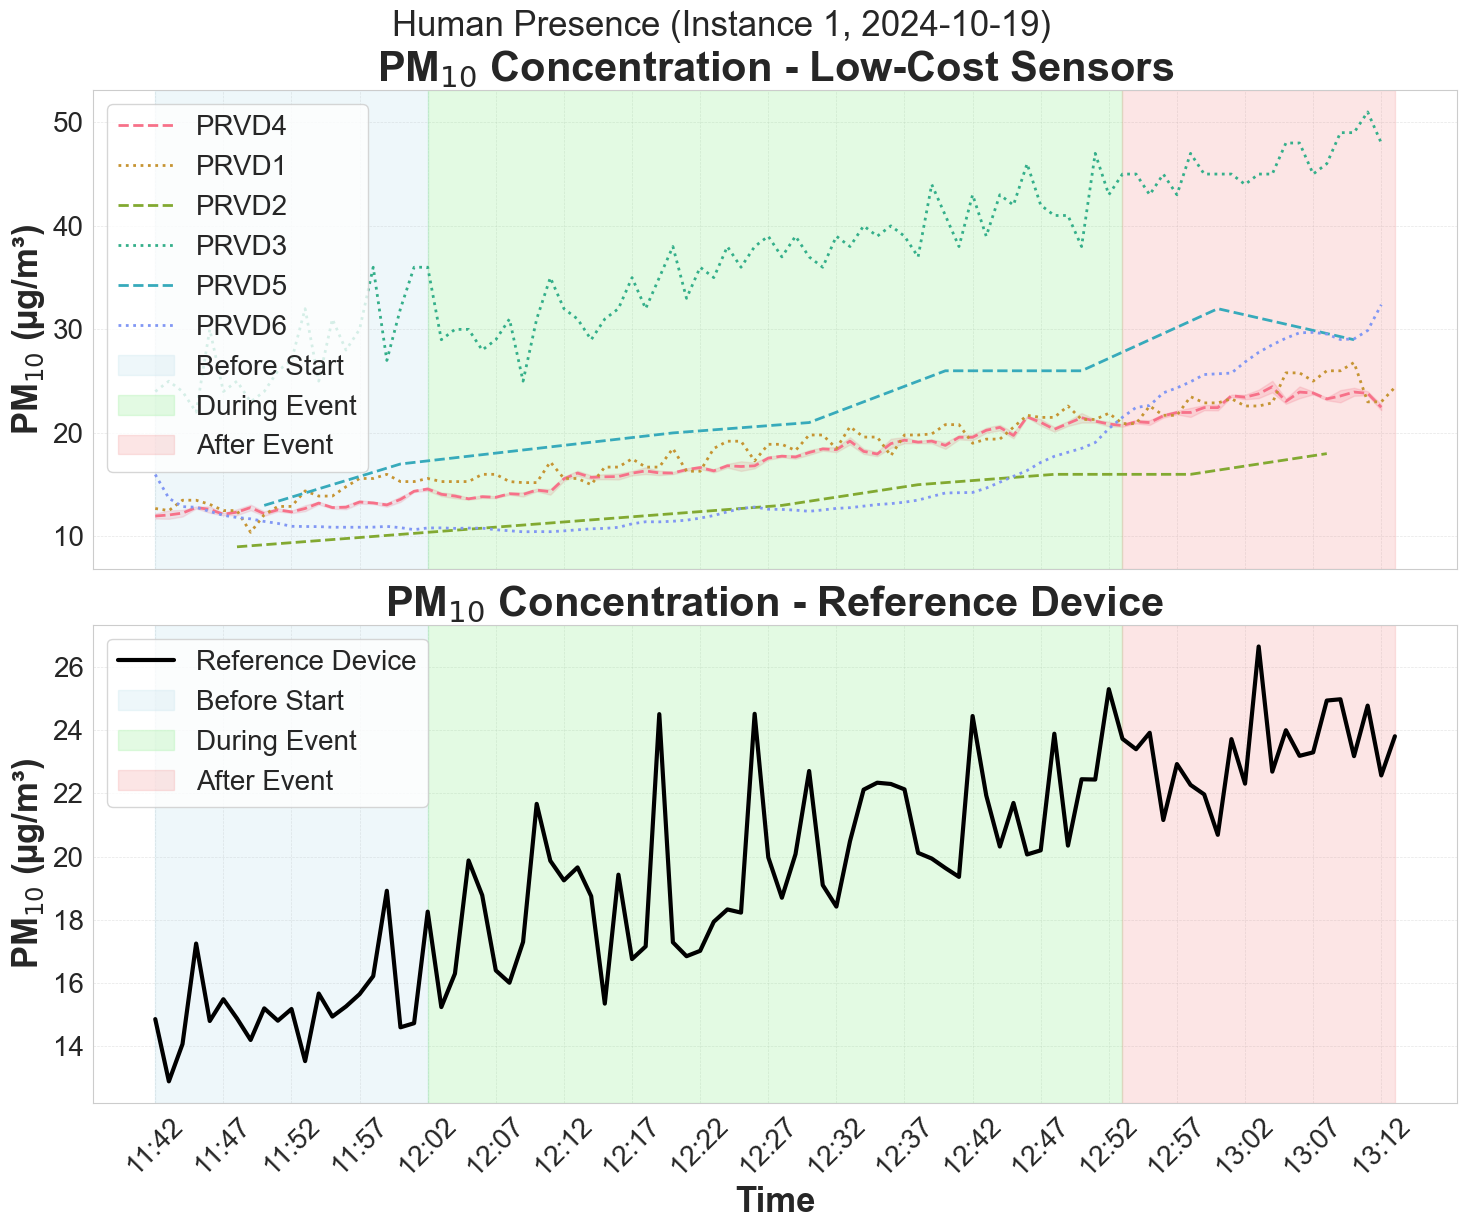

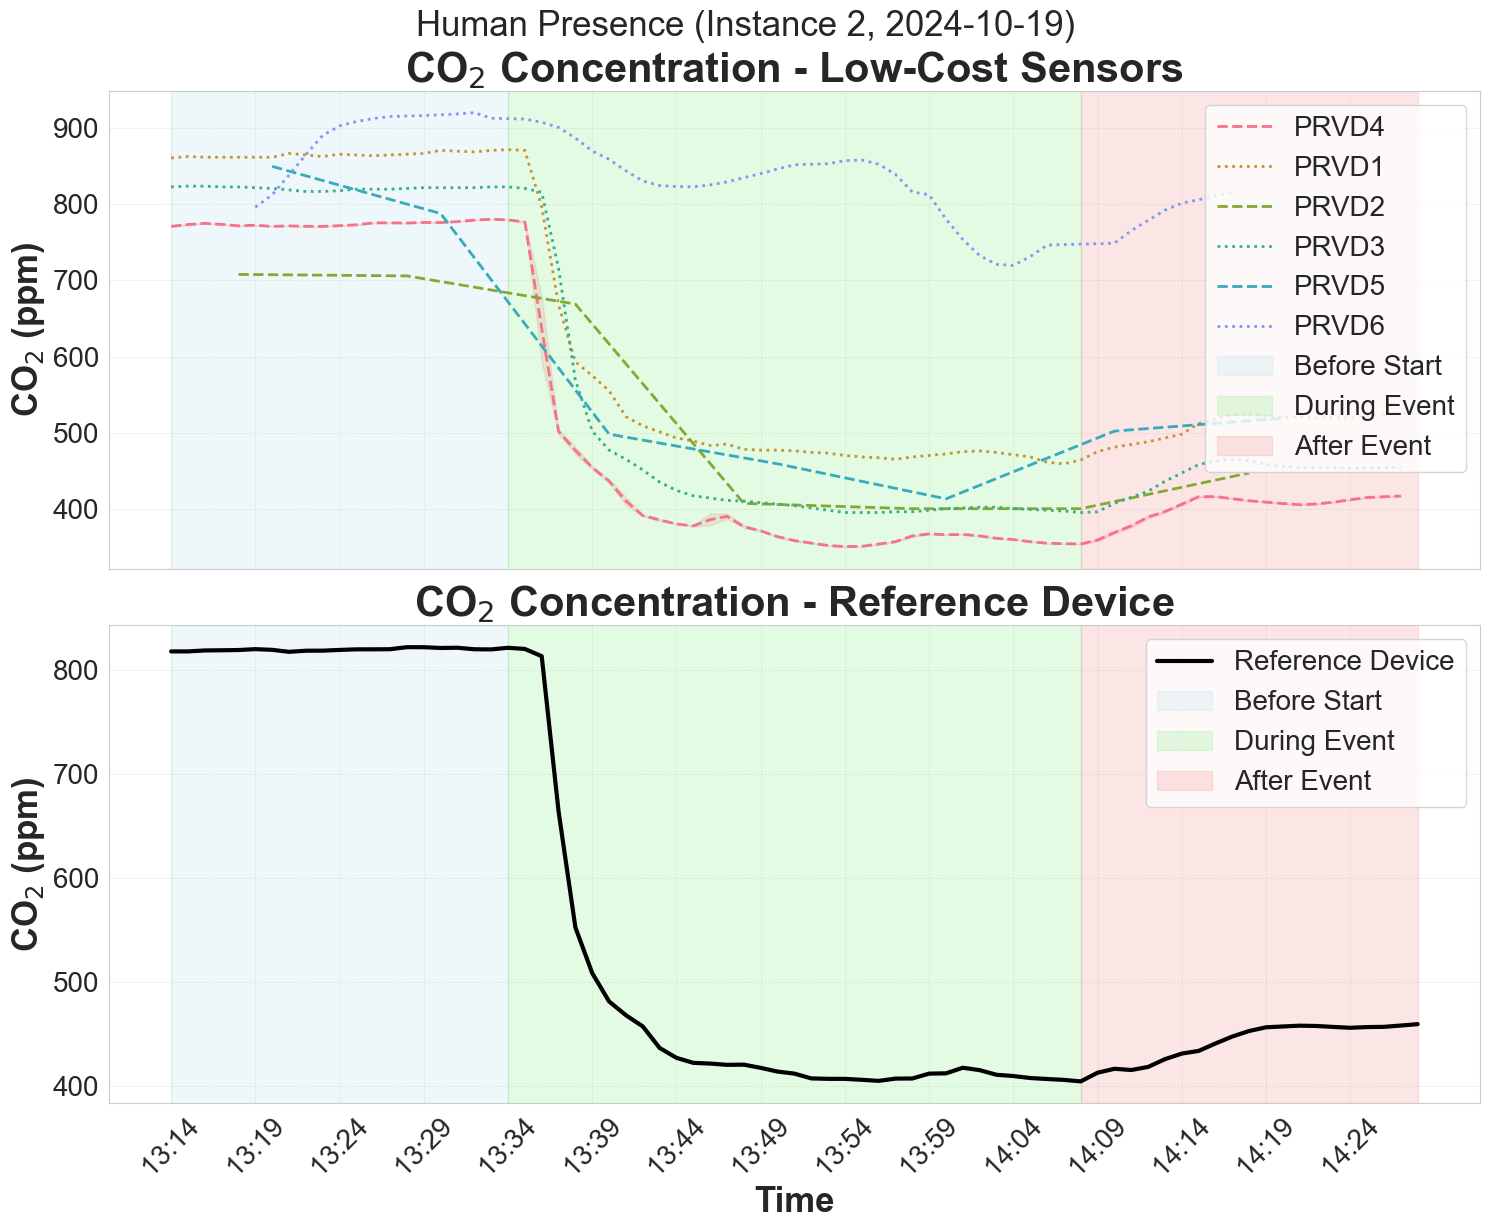

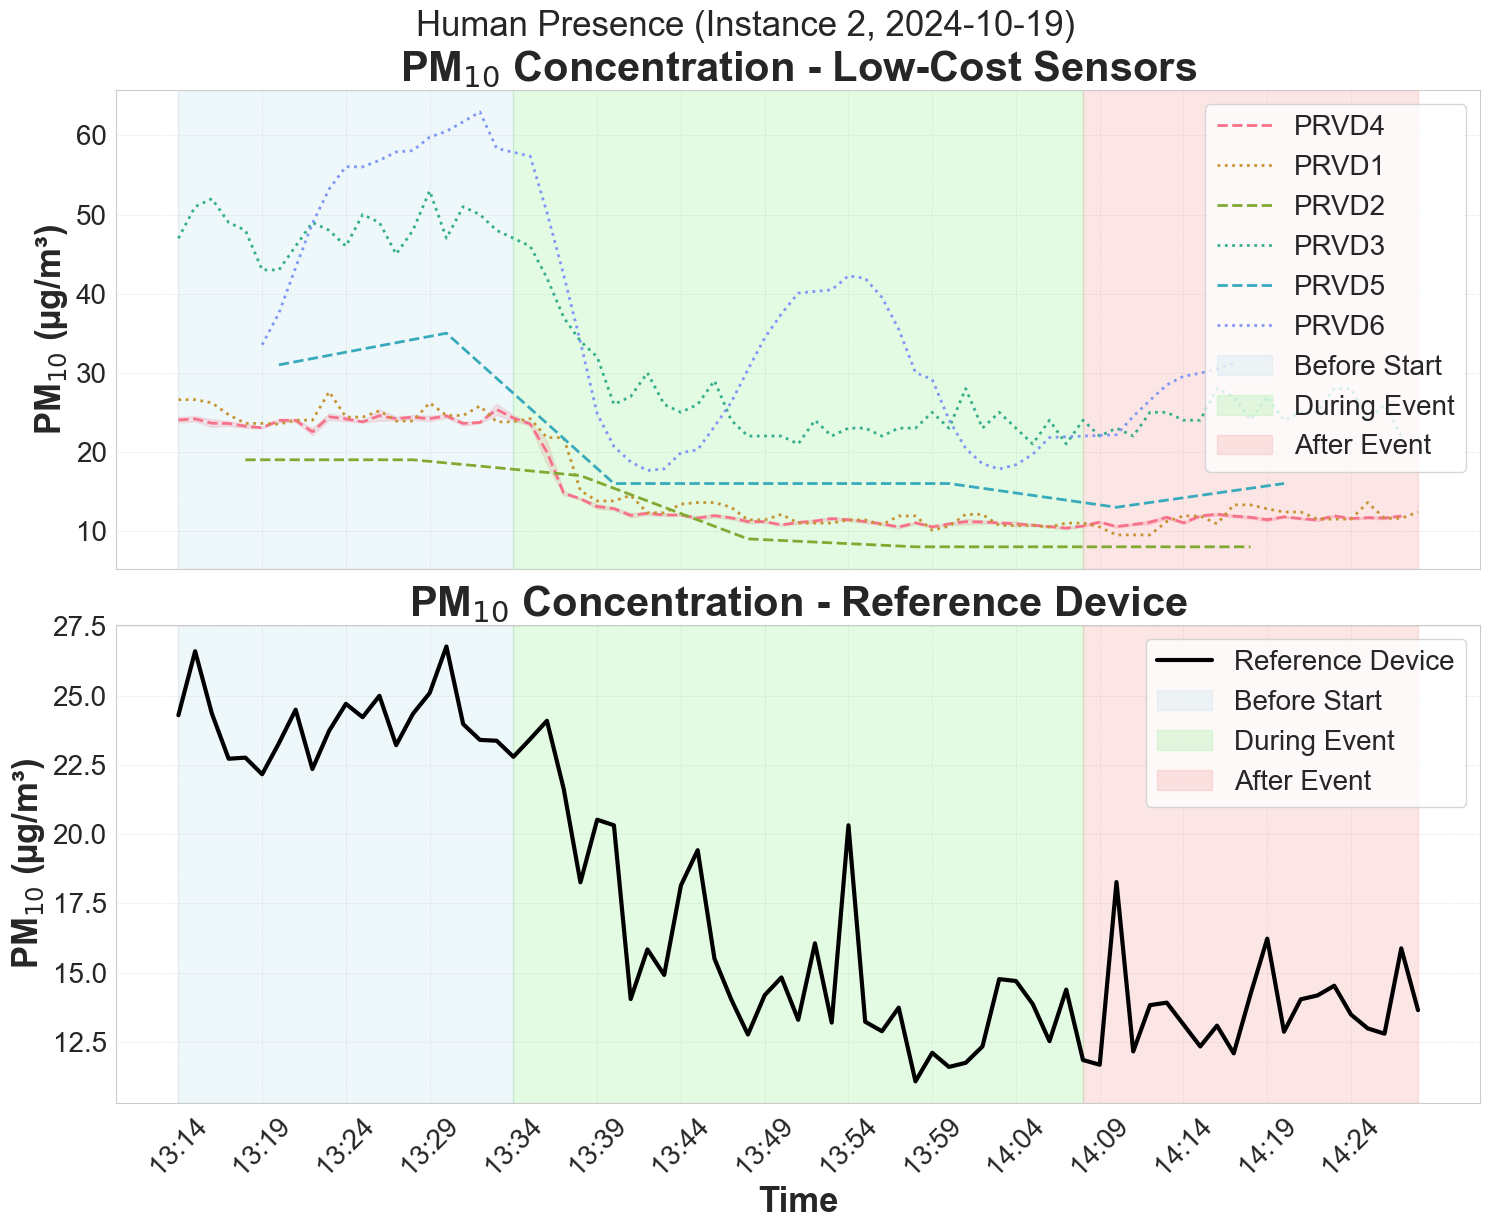

In [18]:

experiment_data = experiments_data['experiments'][selected_experiment]

if isinstance(experiment_data, list):
    for idx, instance in enumerate(experiment_data):
        start_time = pd.Timestamp(instance['start']).strftime('%H:%M')
        end_time = pd.Timestamp(instance['end']).strftime('%H:%M')

        experiment_date = pd.Timestamp(instance['start']).strftime('%Y-%m-%d')

        dfs_cropped = {name: crop_time(df, 
                                    experiment_start=instance['start'], 
                                    experiment_end=instance['end']) 
                    for name, df in dfs.items()}

        for name in dfs_cropped:
            dfs_cropped[name].index = dfs_cropped[name].index.strftime('%H:%M')
            
        fig, axes = plot_comparison_chart(
            dfs=dfs_cropped,
            columns_dict=co2_columns,
            names_dict=names,
            start_time=start_time,
            end_time=end_time,
            param_name='CO',
            param_symbol='2',
            param_unit='ppm',
            ref_col_name='CO2 [ppm]'
        )
        
        fig.suptitle(f"{selected_experiment} (Instance {idx+1}, {experiment_date})", 
                    fontsize=25, y=1.02)
        plt.show()

        fig, axes = plot_comparison_chart(
            dfs=dfs_cropped,
            columns_dict=pm10_columns,
            names_dict=names,
            start_time=start_time,
            end_time=end_time,
            param_name='PM',
            param_symbol='10',
            param_unit='µg/m³',
            ref_col_name='PM10 [µg/m³]'
        )
        
        fig.suptitle(f"{selected_experiment} (Instance {idx+1}, {experiment_date})", 
                    fontsize=25, y=1.02)
        plt.show()
        
else:
    start_time = pd.Timestamp(experiment_data['start']).strftime('%H:%M')
    end_time = pd.Timestamp(experiment_data['end']).strftime('%H:%M')

    dfs_cropped = {name: crop_time(df, 
                                experiment_start=experiment_data['start'], 
                                experiment_end=experiment_data['end']) 
                for name, df in dfs.items()}
    
    for name in dfs_cropped:
        dfs_cropped[name].index = dfs_cropped[name].index.strftime('%H:%M')
        
    fig, axes = plot_comparison_chart(
        dfs=dfs_cropped,
        columns_dict=co2_columns,
        names_dict=names,
        start_time=start_time,
        end_time=end_time,
        param_name='CO',
        param_symbol='2',
        param_unit='ppm',
        ref_col_name='CO2 [ppm]'
    )
    
    experiment_date = pd.Timestamp(experiment_data['start']).strftime('%Y-%m-%d')
    fig.suptitle(f"{selected_experiment} ({experiment_date})", fontsize=25, y=1.02)
    plt.show()
    
    fig, axes = plot_comparison_chart(
        dfs=dfs_cropped,
        columns_dict=pm10_columns,
        names_dict=names,
        start_time=start_time,
        end_time=end_time,
        param_name='PM',
        param_symbol='10',
        param_unit='µg/m³',
        ref_col_name='PM10 [µg/m³]'
    )
    
    fig.suptitle(f"{selected_experiment} ({experiment_date})", fontsize=25, y=1.02)
    plt.show()